In [1]:
import os
os.path

from datetime import datetime, timedelta
import cmocean

import pyproj
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import trajan as ta
import pandas as pd

import opendrift
from opendrift.models.oceandrift import OceanDrift
from opendrift.readers import reader_netCDF_CF_generic
from opendrift.models.physics_methods import wind_drift_factor_from_trajectory, distance_between_trajectories, skillscore_liu_weissberg

import cartopy.crs as ccrs
from matplotlib.lines import Line2D

from scipy.spatial import ConvexHull, convex_hull_plot_2d

## Functions

In [2]:
def reproject(latitude, longitude):
    """Returns the x & y coordinates in meters using a sinusoidal projection"""
    from math import pi, cos, radians
    earth_radius = 6371009 # in meters
    lat_dist = pi * earth_radius / 180.0

    y = [lat * lat_dist for lat in latitude]
    x = [long * lat_dist * cos(radians(lat)) 
                for lat, long in zip(latitude, longitude)]
    return x, y

def area_of_polygon(x, y):
    """Calculates the area of an arbitrary polygon given its verticies"""
    area = 0.0
    for i in range(-1, len(x)-1):
        area += x[i] * (y[i+1] - y[i-1])
    return abs(area) / 2.0

def mean_point(x, y):
    centroid = (sum(x) / len(x), sum(y) / len(y))
    return centroid

## FORWARD

In [3]:
reader_globcur = reader_netCDF_CF_generic.Reader("C:/Users/bente/Documents/THESIS/Globcurrent/*.nc")

In [45]:
duration = timedelta(hours=48)                # 2 days
start_time = datetime(2023,1,23,3,12,8)
end_time = start_time + duration

In [5]:
outfile = "D:/backtrack/oceandrift_48h/retrofl_fwd_randompick.nc"

### Agulhas Current range

In [46]:
lons = np.arange(15, 24, .1/2) 
lats = np.arange(-43, -36, .05/2)
corners = [lons[0], lons[-1], lats[0], lats[-1]]
lons, lats = np.meshgrid(lons, lats)

In [7]:
ofwd = OceanDrift(loglevel=50)
ofwd.add_reader([reader_globcur])
ofwd.seed_elements(lon=lons, lat=lats, radius=0, time=start_time)
ofwd.run(duration=duration, time_step=900, time_step_output=3600, outfile=outfile)

In [8]:
fwd = xr.open_dataset(outfile)

In [12]:
traj = np.arange(0,len(fwd.trajectory),1)

In [15]:
### Calculating lons and lats for the end of the trajectories ### 
lon = []
lat = []
lonend = []
latend = []
for j in range(len(fwd.trajectory)):
    lon.append(fwd.isel(trajectory=j).lon.values)
    lat.append(fwd.isel(trajectory=j).lat.values)
    lonend.append(fwd.isel(trajectory=j).lon.values[-1])   # lon at end of trajectory
    latend.append(fwd.isel(trajectory=j).lat.values[-1])   # lat at end of trajectory

geod = pyproj.Geod(ellps='WGS84')
on = np.ones(len(lonend))

In [16]:
lon = pd.DataFrame(lon)
lat = pd.DataFrame(lat)

In [17]:
lon.to_pickle('lon_retrofl_fwd.pkl')
lat.to_pickle('lat_retrofl_fwd.pkl')
np.savetxt('lonend_retrofl_fwd.out', lonend, delimiter=',')
np.savetxt('latend_retrofl_fwd.out', latend, delimiter=',')

In [47]:
lon = pd.read_pickle('C:/Users/bente/Documents/BACKTRACK/pick_random_fwd_as_truth_oceandrift_48h/lon_retrofl_fwd.pkl')
lat = pd.read_pickle('C:/Users/bente/Documents/BACKTRACK/pick_random_fwd_as_truth_oceandrift_48h/lat_retrofl_fwd.pkl')
lonend = np.loadtxt('C:/Users/bente/Documents/BACKTRACK/pick_random_fwd_as_truth_oceandrift_48h/lonend_retrofl_fwd.out')
latend = np.loadtxt('C:/Users/bente/Documents/BACKTRACK/pick_random_fwd_as_truth_oceandrift_48h/latend_retrofl_fwd.out')

In [48]:
n = []
sepdis_fwd = []
area_fwd = []
ilon = []
ilat = []
startlon = []
startlat = []
a_traj = []
for i in range(1000):
    a = np.random.choice(traj)
    a_traj.append(a)
    iloni = fwd.isel(trajectory=a).lon.values[-1]
    ilon.append(iloni)
    ilati = fwd.isel(trajectory=a).lat.values[-1]
    ilat.append(ilati)
    startloni = fwd.isel(trajectory=a).lon.values[0]
    startlon.append(startloni)
    startlati = fwd.isel(trajectory=a).lat.values[0]
    startlat.append(startlati)
    if iloni<1e10 and ilati<1e10:
        geod = pyproj.Geod(ellps='WGS84')
        on = np.ones(len(lonend))
        dummy1, dummy2, dist2incident = geod.inv(lonend, latend, iloni*on, ilati*on)
        hits = pd.DataFrame(np.where(dist2incident<5000))
        lenhits = hits.shape[1]
        n.append(lenhits) 
        
        hit_start_lons = []
        hit_start_lats = []
        for m in range(lenhits):
            hit_start_lons.append(np.array(lon.loc[hits[m]][0]))
            hit_start_lats.append(np.array(lat.loc[hits[m]][0]))
            
        ### calculating sep. dist. point of gravity of hits to drifter obs. location ###
        if len(hit_start_lons)>1: 
            centroid_fwd = mean_point(hit_start_lons, hit_start_lats)
            sepdis_fwd.append(ta.skill.distance_between_trajectories(np.array([startloni]), np.array([startlati]), np.array([centroid_fwd[0]]), np.array([centroid_fwd[1]])))
        else:
            sepdis_fwd.append(np.nan)
    
        ### calculating area of convex hull ###
        if lenhits>2 and hit_start_lons.count(hit_start_lons[0]) is not len(hit_start_lons) and hit_start_lats.count(hit_start_lats[0]) is not len(hit_start_lats):
            points = []
            for k in range(lenhits):
                points.append([hit_start_lons[k], hit_start_lats[k]])
            points = np.array(points)
            reshaped_points = points.reshape(-1, 2)
            hull_fwd = ConvexHull(reshaped_points)
            hull_fwd_points = points[hull_fwd.vertices]

            hull_fwd_lon = []
            hull_fwd_lat = []
            for l in range(len(hull_fwd_points)):
                hull_fwd_lon.append(hull_fwd_points[l,0])
                hull_fwd_lat.append(hull_fwd_points[l,1])
            repro_fwd = reproject(hull_fwd_lon, hull_fwd_lat)
            area_fwd.append(area_of_polygon(repro_fwd[0],repro_fwd[1]))
        else: 
            area_fwd.append(np.nan)
    
    else: 
        n.append(np.nan)
        sepdis_fwd.append(np.nan)
        area_fwd.append(np.nan)

### BACKWARD

In [49]:
outfile_back = []
for i in range(1000):
    outfile_back.append("D:/backtrack/oceandrift_48h/random_pick/retrofl_back_1000_"+str(i)+".nc")

In [50]:
for i in range(1000):
    orev = OceanDrift(loglevel=50)
    orev.add_reader([reader_globcur])
    if n[i]>0 and ilon[i]<1e10 and ilat[i]<1e10:
        orev.seed_elements(lon=ilon[i], lat=ilat[i], radius=5000, radius_type='uniform', number=n[i],
                         time=end_time)
        orev.run(duration=duration, time_step=-900, time_step_output=3600, outfile=outfile_back[i])

In [23]:
sims_back = []
for i in range(1000):
    if n[i]>0 and ilon[i]<1e10 and ilat[i]<1e10:
        sims_back.append(xr.open_dataset(outfile_back[i]))     # For the forward runs with hits
    else: 
        sims_back.append(np.nan)                               # For the forward runs without hits

In [24]:
sims_back[0]>0

<xarray.Dataset>
Dimensions:                                                                              (
                                                                                          trajectory: 8,
                                                                                          time: 49)
Coordinates:
  * trajectory                                                                           (trajectory) int32 ...
  * time                                                                                 (time) datetime64[ns] ...
Data variables: (12/28)
    status                                                                               (trajectory, time) bool ...
    moving                                                                               (trajectory, time) bool ...
    age_seconds                                                                          (trajectory, time) bool ...
    origin_marker                                                                        (trajectory, time) bool ...
    lon                                                                                  (trajectory, time) bool ...
    lat                                                                                  (trajectory, time) bool ...
    ...                                                                                   ...
    surface_downward_y_stress                                                            (trajectory, time) bool ...
    turbulent_kinetic_energy                                                             (trajectory, time) bool ...
    turbulent_generic_length_scale                                                       (trajectory, time) bool ...
    ocean_mixed_layer_thickness                                                          (trajectory, time) bool ...
    sea_floor_depth_below_sea_level                                                      (trajectory, time) bool ...
    land_binary_mask                                                                     (trajectory, time) bool ...
Attributes: (12/116)
    Conventions:                                                             ...
    standard_name_vocabulary:                                                ...
    featureType:                                                             ...
    history:                                                                 ...
    source:                                                                  ...
    model_url:                                                               ...
    ...                                                                                                               ...
    geospatial_lat_resolution:                                               ...
    geospatial_lon_min:                                                      ...
    geospatial_lon_max:                                                      ...
    geospatial_lon_units:                                                    ...
    geospatial_lon_resolution:                                               ...
    runtime:                                                                 ...

In [25]:
area_back = []
sepdis_back = []

for i in range(len(sims_back)): 
    if sims_back[i]>0:
        lon = []
        lat = []
        lonend = []
        latend = []
        for j in range(len(sims_back[i].trajectory)):
            lon.append(sims_back[i].isel(trajectory=j).lon.values)
            lat.append(sims_back[i].isel(trajectory=j).lat.values)
            lonend.append(sims_back[i].isel(trajectory=j).lon.values[-1])   # lon at end of trajectory
            latend.append(sims_back[i].isel(trajectory=j).lat.values[-1])   # lat at end of trajectory
       
        ### calculating sep. dist. point of gravity of hits to drifter obs. location ###
        if len(lonend)>1 and len(lonend)<400: 
            centroid_back = mean_point(lonend, latend)
            sepdis_back.append(ta.skill.distance_between_trajectories(np.array([startlon[i]]), np.array([startlat[i]]), np.array([centroid_back[0]]), np.array([centroid_back[1]])))
            
            ### calculating area of convex hull ###
            points_back = []
            for j in range(len(lonend)):
                if lonend[j]<1e10 and latend[j]<1e10:
                    points_back.append([lonend[j], latend[j]])
            points_back = np.array(points_back)

            if len(points_back)>2: 
                hull_back = ConvexHull(points_back)
                hull_back_points = points_back[hull_back.vertices]
                hull_back_lon = []
                hull_back_lat = []
                for l in range(len(hull_back_points)):
                    hull_back_lon.append(hull_back_points[l,0])
                    hull_back_lat.append(hull_back_points[l,1])

                repro_back = reproject(hull_back_lon, hull_back_lat)
                area_back.append(area_of_polygon(repro_back[0],repro_back[1]))

        else:
            area_back.append(np.nan)
            sepdis_back.append(np.nan)
    
    else:
        area_back.append(np.nan)
        sepdis_back.append(np.nan)

In [26]:
points_back

array([[ 16.749893, -42.18782 ],
       [ 16.771126, -42.140736],
       [ 16.728315, -42.1835  ],
       [ 16.790436, -42.18371 ],
       [ 16.758106, -42.151665],
       [ 16.764124, -42.21875 ],
       [ 16.694445, -42.21466 ]], dtype=float32)

In [27]:
area_fwd_new = []
for i in range(len(area_fwd)):
    if area_fwd[i] is not np.nan: 
        area_fwd_new.append(area_fwd[i][0])
    else: 
        area_fwd_new.append(np.nan)

In [28]:
sepdis_fwd_new = []
sepdis_back_new = []
for i in range(len(sepdis_fwd)):
    if sepdis_fwd[i] is not np.nan: 
        sepdis_fwd_new.append(sepdis_fwd[i][0][0])
    else: 
        sepdis_fwd_new.append(np.nan)
    if sepdis_back[i] is not np.nan: 
        sepdis_back_new.append(sepdis_back[i][0])
    else: 
        sepdis_back_new.append(np.nan)

In [38]:
np.savetxt('rfl1000_area_forward.out', area_fwd_new, delimiter=',')
np.savetxt('rfl1000_sepdis_fwd.out', sepdis_fwd_new, delimiter=',')
np.savetxt('rfl1000_area_back.out', area_back, delimiter=',')
np.savetxt('rfl1000_sepdis_back.out', sepdis_back_new, delimiter=',')
np.savetxt('rfl1000_n.out', n, delimiter=',')

Text(0.5, 1.0, 'Area convex hull')

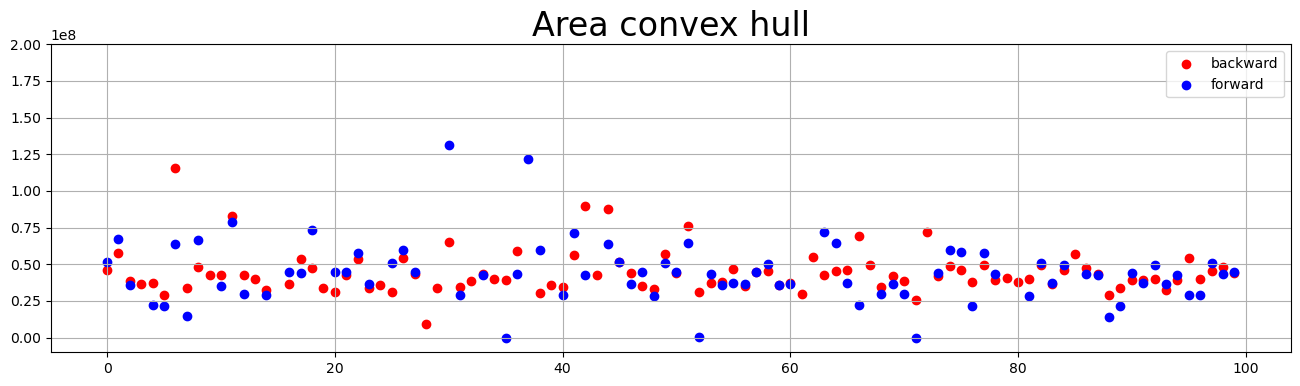

In [30]:
plt.figure(figsize=(16,4))
plt.scatter(range(len(area_back)), area_back, color='red', linestyle='-', label='backward')
plt.scatter(range(len(area_fwd_new)), area_fwd_new, color='blue', linestyle='-', label='forward')

plt.ylim([-10000000,2e8])
plt.legend()
plt.grid()
plt.title('Area convex hull', fontsize=24)

(-10000000.0, 100000000.0)

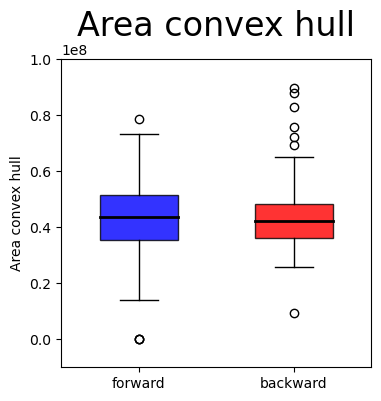

In [31]:
area_back_nan = np.array(area_back)[~np.isnan(np.array(area_back))]
area_forward_nan = np.array(area_fwd_new)[~np.isnan(np.array(area_fwd_new))]

plt.figure(figsize=(4,4))
plt.boxplot(area_back_nan, positions=[2], patch_artist=True, boxprops=dict(facecolor='red', alpha=0.8), medianprops=dict(color='black', linewidth=2), widths = 0.5)
plt.boxplot(area_forward_nan, positions=[1], patch_artist=True, boxprops=dict(facecolor='blue', alpha=0.8), medianprops=dict(color='black', linewidth=2), widths = 0.5)
plt.xticks([1,2],['forward', 'backward'])
plt.ylabel('Area convex hull')
plt.title('Area convex hull', fontsize=24)

plt.ylim([-1e7,1e8])

Text(0.5, 1.0, 'Seperation distance')

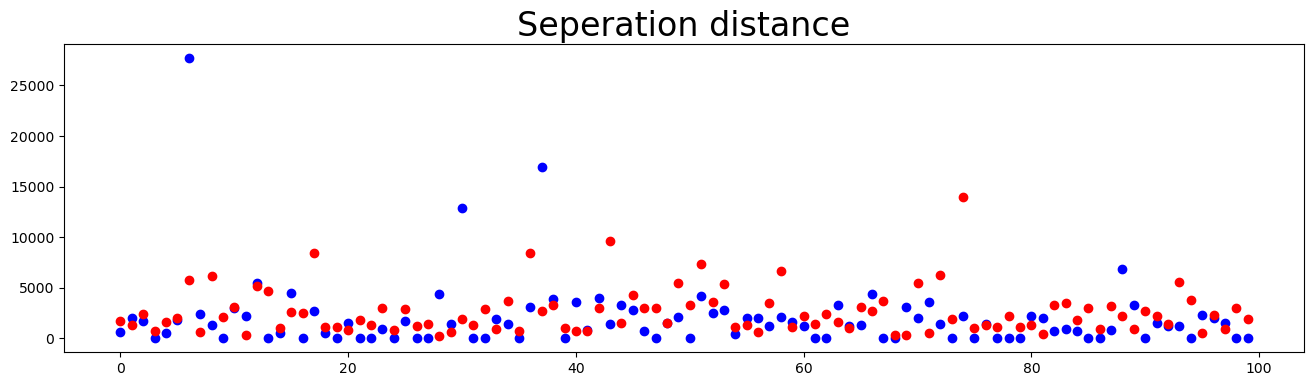

In [32]:
plt.figure(figsize=(16,4))
plt.scatter(range(len(sepdis_fwd_new)),sepdis_fwd_new, color='blue')
plt.scatter(range(len(sepdis_back_new)),sepdis_back_new, color='red')
plt.title('Seperation distance', fontsize=24)

Text(0.5, 1.0, 'Seperation distance')

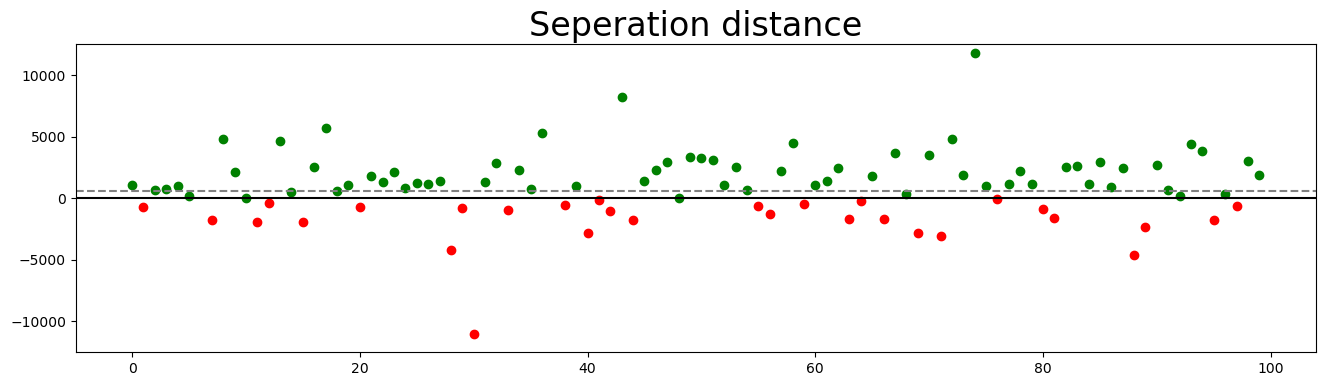

In [33]:
dif = np.array(sepdis_back_new) - np.array(sepdis_fwd_new)
ldif = range(len(dif))
meandif = np.nanmean(dif)

plt.figure(figsize=(16,4))
for i in range(len(dif)):
    if dif[i]>0:
        plt.scatter(ldif[i], dif[i], color='green')
    else:
        plt.scatter(ldif[i], dif[i], color='red')

plt.axhline(y=0, color='black')
plt.axhline(meandif, color='grey', linestyle='--')
plt.ylim([-12500, 12500])
plt.title('Seperation distance', fontsize=24)

(-1000.0, 15000.0)

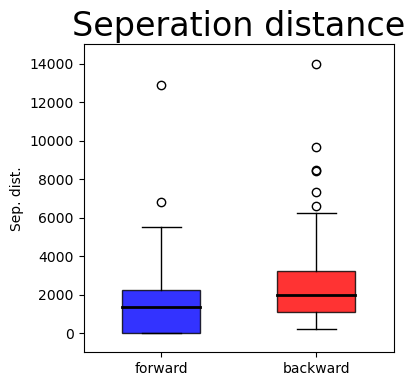

In [34]:
sepdis_back_new_nan = np.array(sepdis_back_new)[~np.isnan(np.array(sepdis_back_new))]
sepdis_fwd_new_nan = np.array(sepdis_fwd_new)[~np.isnan(np.array(sepdis_fwd_new))]

plt.figure(figsize=(4,4))
plt.boxplot(sepdis_back_new_nan, positions=[2], patch_artist=True, boxprops=dict(facecolor='red', alpha=0.8), medianprops=dict(color='black', linewidth=2), widths = 0.5)
plt.boxplot(sepdis_fwd_new_nan, positions=[1], patch_artist=True, boxprops=dict(facecolor='blue', alpha=0.8), medianprops=dict(color='black', linewidth=2), widths = 0.5)
plt.xticks([1,2],['forward', 'backward'])
plt.ylabel('Sep. dist.')
plt.title('Seperation distance', fontsize=24)

plt.ylim([-1000,15000])

(0.0, 27.0)

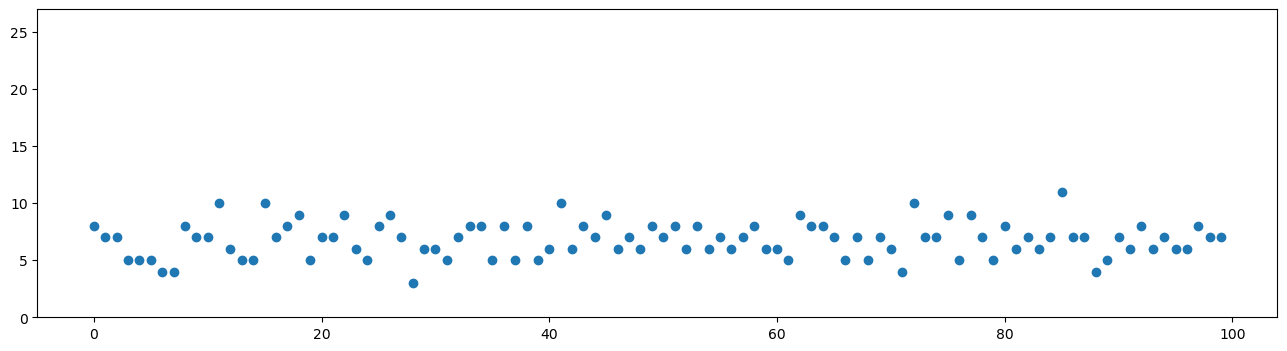

In [35]:
plt.figure(figsize=(16,4))
plt.scatter(range(len(n)),n)
plt.ylim([0,27])

In [36]:
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
from matplotlib.lines import Line2D

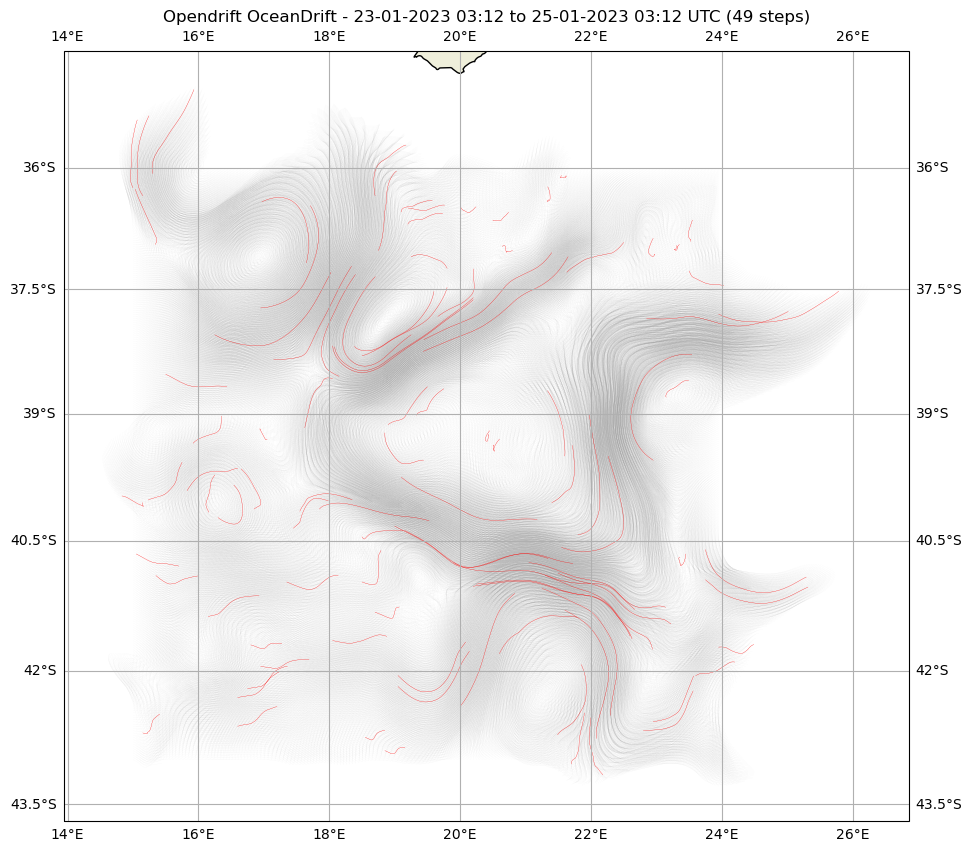

In [41]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection=ccrs.Mercator())
ax.gridlines(draw_labels=True)
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax.add_feature(cartopy.feature.BORDERS)

fwd.traj.plot(linewidth=0.1, color='grey')

for i in a_traj:
    fwd.isel(trajectory=i).traj.plot(linewidth=0.2, color='red')

    
plt.gca().autoscale()
plt.title('Opendrift OceanDrift - 23-01-2023 03:12 to 25-01-2023 03:12 UTC (49 steps)')
plt.show() 

In [40]:
a_traj

[2732,
 43567,
 42613,
 45891,
 21243,
 30403,
 32103,
 41993,
 20757,
 46884,
 14935,
 15430,
 48600,
 39512,
 14650,
 17089,
 32230,
 18983,
 43095,
 24152,
 35665,
 16921,
 27469,
 38984,
 6921,
 38804,
 2163,
 5072,
 37619,
 7877,
 18430,
 1871,
 7599,
 2496,
 47954,
 24675,
 42968,
 31921,
 33523,
 797,
 49811,
 3219,
 15246,
 24999,
 16321,
 19129,
 41504,
 49866,
 18676,
 31230,
 11723,
 43890,
 17591,
 43136,
 26752,
 23605,
 6021,
 20006,
 3560,
 25332,
 31055,
 45444,
 46522,
 47647,
 21368,
 20737,
 28647,
 26681,
 14627,
 12134,
 47883,
 41390,
 20571,
 9781,
 19340,
 27257,
 16298,
 12372,
 4420,
 45830,
 39876,
 17455,
 14324,
 38019,
 7012,
 9396,
 47080,
 3918,
 9359,
 44259,
 23482,
 15127,
 43727,
 35725,
 37237,
 14165,
 8752,
 42565,
 14505,
 5795]